# Final Project: Basketball Dataset
In this project, we will analyze the college basketball dataset to attempt to determine the success of college players in the NBA. Specifically, we will try to develop a model that can predict the NBA ppg of a player given all of their NCAA statistics.

In [1]:
# Importing necessary packages and functions.
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [2]:
# Reading in our data and creating an identical dataset that will hold our cleaned data.
raw = pd.read_csv("college.csv")
cleaned = raw
raw.head()

,Unnamed: 0,active_from,active_to,birth_date,college,height,name,position,url,weight,...,NCAA__3ptpg,NCAA_efgpct,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
0,0,1991,1995,"June 24, 1968",Duke University,6-10,Alaa Abdelnaby,F-C,/players/a/abdelal01.html,240.0,...,0.0,NaN,5.6,0.599,3.3,0.728,2.5,1.8,134.0,8.5
1,1,1969,1978,"April 7, 1946",Iowa State University,6-9,Zaid Abdul-Aziz,C-F,/players/a/abdulza01.html,235.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1970,1989,"April 16, 1947","University of California, Los Angeles",7-2,Kareem Abdul-Jabbar,C,/players/a/abdulka01.html,225.0,...,NaN,NaN,16.8,0.639,10.7,0.628,7.9,5.0,88.0,26.4
3,3,1991,2001,"March 9, 1969",Louisiana State University,6-1,Mahmoud Abdul-Rauf,G,/players/a/abdulma02.html,162.0,...,2.7,NaN,21.9,0.474,10.4,0.863,6.4,5.5,64.0,29.0
4,4,1998,2003,"November 3, 1974","University of Michigan, San Jose State University",6-6,Tariq Abdul-Wahad,F,/players/a/abdulta01.html,223.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Given this table, we want to predict the NBA_ppg of every player, solely based on their NCAA statistics and other features. Some potentially useful features include height, position, age entering the NBA, and years in the NBA. The following cells add these cells into the "cleaned" dataframe.

In [3]:
# Function that takes in a string of the format 'feet-inches' and returns total height in inches. Ex: '6-10' becomes 82
r_height = re.compile(r"(.*)-(.*)")
def get_height(height):
    if height.__str__() == 'nan':
        return float('NaN')
    m = r_height.match(height)
    if m == None:
        return float('NaN')
    else:
        return int(m.group(1))*12 + int(m.group(2))

In [4]:
# Function that takes in a dataset with the column 'position' and one hot encodes position into new columns. Sourced from
# hw6 in UC Berkeley Data 100.
def ohe_position(data):
    vec_enc = DictVectorizer()
    vec_enc.fit(data[['position']].to_dict(orient='records'))
    position_data = vec_enc.transform(data[['position']].to_dict(orient='records')).toarray()
    position_cats = vec_enc.get_feature_names()
    position = pd.DataFrame(position_data, columns=position_cats)
    data = pd.concat([data, position], axis=1)
    data = data.drop(columns=position_cats[0])
    return data

In [5]:
# One-hot-encoding categorical variable 'position' to usable columns for modeling.
cleaned = ohe_position(raw)

# Adding the column 'age_entering_NBA' that calculates the approximate age of players when they enter the NBA.
cleaned['age_entering_NBA'] = raw['active_from'] - pd.to_datetime(raw['birth_date']).dt.year

# Adding the column 'year_in_NBA' that calculates the approximate number of years spent in the NBA.
cleaned['years_in_NBA'] = raw['active_to'] - raw['active_from']

# Adding the column 'height_inches' that calculates the heights of players in inches.
cleaned['height_inches'] = raw['height'].apply(get_height)

# Dropping columns that will be unused in future modeling purposes. Also dropping NCAA_efgpct, as it is null for
# all rows.
cleaned = cleaned.drop(['Unnamed: 0', 'active_from', 'active_to', 'birth_date', 'height', 'url',
              'NBA__3ptapg', 'NBA__3ptpct', 'NBA__3ptpg', 'NBA_efgpct', 'NBA_fg%', 'NBA_fg_per_game',
              'NBA_fga_per_game', 'NBA_ft%', 'NBA_ft_per_g', 'NBA_fta_p_g', 'NBA_g_played', 'NCAA_efgpct'], axis=1)
cleaned.head()

,college,name,weight,NBA_ppg,NCAA__3ptapg,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,...,position=C,position=C-F,position=F,position=F-C,position=F-G,position=G,position=G-F,age_entering_NBA,years_in_NBA,height_inches
0,Duke University,Alaa Abdelnaby,240.0,5.7,0.0,NaN,0.0,5.6,0.599,3.3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23.0,4,82.0
1,Iowa State University,Zaid Abdul-Aziz,235.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,23.0,9,81.0
2,"University of California, Los Angeles",Kareem Abdul-Jabbar,225.0,24.6,NaN,NaN,NaN,16.8,0.639,10.7,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,19,86.0
3,Louisiana State University,Mahmoud Abdul-Rauf,162.0,14.6,7.2,0.372,2.7,21.9,0.474,10.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22.0,10,73.0
4,"University of Michigan, San Jose State University",Tariq Abdul-Wahad,223.0,7.8,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24.0,5,78.0


Simply looking at a preview of our data, we notice a lot of "NaN" values. We also may have some of these in our height column. Let's count these:

In [6]:
missing_counts = cleaned.isnull().sum().sort_values(ascending=False)
missing_counts

NCAA__3ptpct        2850
NCAA__3ptapg        2708
NCAA__3ptpg         2705
NCAA_fgapg          1994
NCAA_fgpct          1993
NCAA_ftapg          1984
NCAA_ft             1982
NCAA_ftpg           1978
NCAA_games          1978
NCAA_fgpg           1978
NCAA_ppg            1978
college              302
age_entering_NBA      29
weight                 6
height_inches          1
years_in_NBA           0
position=C             0
position=C-F           0
position=F             0
position=F-C           0
position=F-G           0
position=G             0
position=G-F           0
NBA_ppg                0
name                   0
dtype: int64

For each of these NaN values, we will identify the cause of them and address the values accordingly. Let's start from the bottom and work upwards and address height_inches, weight, age_entering_NBA, and college. For these, let's consult our raw data to see what information is available and if these players are worth considering for our purposes.

In [7]:
raw.loc[cleaned['height_inches'].isnull() == True].head()

,Unnamed: 0,active_from,active_to,birth_date,college,height,name,position,url,weight,...,NCAA__3ptpg,NCAA_efgpct,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
2152,2152,1974,1978,"May 12, 1952",University of North Carolina,NaN,George Karl,NaN,/players/k/karlge01.html,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
raw.loc[cleaned['weight'].isnull() == True].head()

,Unnamed: 0,active_from,active_to,birth_date,college,height,name,position,url,weight,...,NCAA__3ptpg,NCAA_efgpct,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
2152,2152,1974,1978,"May 12, 1952",University of North Carolina,NaN,George Karl,NaN,/players/k/karlge01.html,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2372,2372,1968,1968,NaN,University of Washington,6-6,Dick Lee,F,/players/l/leedi01.html,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2798,2798,1950,1950,"March 19, 1923",Sam Houston State University,6-6,Murray Mitchell,C,/players/m/mitchmu01.html,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2991,2991,1954,1954,"September 3, 1929",Texas Tech University,6-10,Paul Nolen,C,/players/n/nolenpa01.html,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4304,4304,1947,1948,"January 1, 1922",St. John's University,5-11,Ray Wertis,G,/players/w/wertira01.html,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
raw.loc[cleaned['age_entering_NBA'].isnull() == True].head()

,Unnamed: 0,active_from,active_to,birth_date,college,height,name,position,url,weight,...,NCAA__3ptpg,NCAA_efgpct,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
49,49,1968,1968,NaN,New Mexico State University,6-8,Bill Allen,C-F,/players/a/allenbi01.html,205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317,317,1956,1956,NaN,Valparaiso University,6-7,Don Bielke,C,/players/b/bielkdo01.html,240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474,474,1971,1971,NaN,Temple University,6-4,Clarence Brookins,F,/players/b/brookcl01.html,190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
586,586,1970,1970,NaN,Temple University,6-7,Walter Byrd,F,/players/b/byrdwa01.html,205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
801,801,1947,1947,NaN,Oklahoma State Teachers College,6-5,Ken Corley,C,/players/c/corleke01.html,210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
raw.loc[cleaned['college'].isnull() == True].head()

,Unnamed: 0,active_from,active_to,birth_date,college,height,name,position,url,weight,...,NCAA__3ptpg,NCAA_efgpct,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,NCAA_ft,NCAA_ftapg,NCAA_ftpg,NCAA_games,NCAA_ppg
9,9,2017,2018,"August 1, 1993",NaN,6-6,Alex Abrines,G-F,/players/a/abrinal01.html,190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,32,2009,2017,"May 6, 1988",NaN,7-2,Alexis Ajinca,C,/players/a/ajincal01.html,248.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,38,2015,2015,"August 9, 1991",NaN,6-10,Furkan Aldemir,F-C,/players/a/aldemfu01.html,240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,74,2010,2011,"June 23, 1980",NaN,6-11,David Andersen,C,/players/a/anderda03.html,245.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,100,2006,2006,"March 12, 1986",NaN,7-2,Martynas Andriuskevicius,C,/players/a/andrima01.html,240.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It isn't much of a surprise that for nearly all these players, there is no available information on their NCAA statistics, most likely because they either did not play in the NCAA (those with no college), or the information simply wasn't recorded. We can safely remove all of these players from our dataset and proceed forward.

In [11]:
# Removing all players with NaN values in any of the aforementioned columns.
cleaned = cleaned.loc[(cleaned['height_inches'].isnull() == False) & (cleaned['weight'].isnull() == False) &
                      (cleaned['age_entering_NBA'].isnull() == False) & (cleaned['college'].isnull() == False)]
missing_counts = cleaned.isnull().sum().sort_values(ascending=False)
missing_counts

NCAA__3ptpct        2515
NCAA__3ptapg        2373
NCAA__3ptpg         2370
NCAA_fgapg          1659
NCAA_fgpct          1658
NCAA_ftapg          1649
NCAA_ft             1647
NCAA_ftpg           1643
NCAA_ppg            1643
NCAA_games          1643
NCAA_fgpg           1643
name                   0
weight                 0
NBA_ppg                0
height_inches          0
years_in_NBA           0
position=C             0
position=C-F           0
position=F             0
position=F-C           0
position=F-G           0
position=G             0
position=G-F           0
age_entering_NBA       0
college                0
dtype: int64

The players without any NCAA statistics naturally have no ppg, so let's remove these players and see how the numbers change.

In [12]:
# Removing all players with a NaN value in the NCAA_ppg column.
cleaned = cleaned.loc[(cleaned['NCAA_ppg'].isnull() == False)]
missing_counts = cleaned.isnull().sum().sort_values(ascending=False)
missing_counts

NCAA__3ptpct        872
NCAA__3ptapg        730
NCAA__3ptpg         727
NCAA_fgapg           16
NCAA_fgpct           16
NCAA_ftapg            6
NCAA_ft               6
height_inches         0
name                  0
weight                0
NBA_ppg               0
NCAA_fgpg             0
NCAA_ftpg             0
years_in_NBA          0
NCAA_games            0
NCAA_ppg              0
position=C            0
position=C-F          0
position=F            0
position=F-C          0
position=F-G          0
position=G            0
position=G-F          0
age_entering_NBA      0
college               0
dtype: int64

At this point, we have 6 players with only NCAA fgpg, ftpg, games, and ppg. We have 10 players with only those four statistics, ftapg, and ft. Although these players have some NCAA statistics, they will not prove particularly helpful in training our model, so we will remove them.

In [13]:
# Removing players that have a NaN value in the NCAA_fgapg column.
cleaned = cleaned.loc[cleaned['NCAA_fgapg'].isnull() == False]
missing_counts = cleaned.isnull().sum().sort_values(ascending=False)
missing_counts

NCAA__3ptpct        856
NCAA__3ptapg        714
NCAA__3ptpg         711
height_inches         0
NCAA_ftapg            0
name                  0
weight                0
NBA_ppg               0
NCAA_fgapg            0
NCAA_fgpct            0
NCAA_fgpg             0
NCAA_ft               0
NCAA_ftpg             0
years_in_NBA          0
NCAA_games            0
NCAA_ppg              0
position=C            0
position=C-F          0
position=F            0
position=F-C          0
position=F-G          0
position=G            0
position=G-F          0
age_entering_NBA      0
college               0
dtype: int64

Now, all our NaN values are concentrated in columns relating to NCAA 3-point statistics. Closer examination of the raw dataset and some research provides some insights into this - the NCAA 3-point line was not implemented until 1986, and so 711 players have no statistics for their NCAA 3-point shots made per game (3ptpg), attempted per game (3ptapg), or percentage (3ptpct). There are 3 players with a 0 in the 3ptpg column, but a NaN in the 3ptapg. There are 142 more players with a 0 in the 3ptpg and 3ptapg columns, but a NaN in the 3ptpct column. The 711 players with no NCAA 3-point statistics will be placed into a separate dataframe and saved for possible future use (if we find that our model makes little to no use of NCAA 3-point statistics, we will add them back to our dataset). The 3 players will be removed, as I honestly have no reasonable explanation for their information. The 142 players will be given a 0 in the NCAA__3ptpct column, as they attempted no 3 pointers and made no 3 pointers, yielding a whopping 0% 3-point percentage.

The following cells display information that helped make these conclusions and modify our data accordingly.

In [14]:
cleaned.loc[(cleaned['NCAA__3ptpg'].isnull() == False) & (cleaned['NCAA__3ptapg'].isnull() == True)]

,college,name,weight,NBA_ppg,NCAA__3ptapg,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,...,position=C,position=C-F,position=F,position=F-C,position=F-G,position=G,position=G-F,age_entering_NBA,years_in_NBA,height_inches
2034,Western Kentucky University,Kannard Johnson,220.0,0.5,NaN,NaN,0.0,10.3,0.536,5.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23.0,0,81.0
2437,University of Kentucky,Rob Lock,225.0,1.5,NaN,NaN,0.0,4.1,0.538,2.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23.0,0,81.0
2615,Purdue University,Mel McCants,240.0,1.7,NaN,NaN,0.0,8.1,0.562,4.6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,23.0,0,80.0


In [15]:
cleaned.loc[(cleaned['NCAA__3ptpg'].isnull() == False) & (cleaned['NCAA__3ptpct'].isnull() == True)]

,college,name,weight,NBA_ppg,NCAA__3ptapg,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,...,position=C,position=C-F,position=F,position=F-C,position=F-G,position=G,position=G-F,age_entering_NBA,years_in_NBA,height_inches
0,Duke University,Alaa Abdelnaby,240.0,5.7,0.0,NaN,0.0,5.6,0.599,3.3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23.0,4,82.0
21,University of Pittsburgh,Steven Adams,255.0,8.7,0.0,NaN,0.0,5.5,0.571,3.1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,4,84.0
23,University of Kentucky,Bam Adebayo,243.0,6.9,0.0,NaN,0.0,7.5,0.599,4.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,21.0,0,82.0
39,University of Kansas,Cole Aldrich,250.0,3.1,0.0,NaN,0.0,6.1,0.574,3.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,7,83.0
40,University of Texas at Austin,LaMarcus Aldridge,260.0,19.4,0.0,NaN,0.0,8.9,0.586,5.2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,22.0,11,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4416,Stetson University,Lorenzo Williams,200.0,3.0,0.0,NaN,0.0,7.1,0.530,3.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,7,81.0
4438,Boston College,Sean Williams,235.0,4.2,0.0,NaN,0.0,3.5,0.577,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,22.0,4,82.0
4466,Louisiana State University,Nikita Wilson,200.0,1.3,0.0,NaN,0.0,9.4,0.543,5.1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24.0,0,80.0
4520,University of North Carolina,Brandan Wright,210.0,7.0,0.0,NaN,0.0,9.5,0.646,6.2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,21.0,10,82.0


In [16]:
cleaned = cleaned.loc[~((cleaned['NCAA__3ptpg'].isnull() == False) & (cleaned['NCAA__3ptapg'].isnull() == True))]
no_NCAA_3_point = cleaned.loc[cleaned['NCAA__3ptpg'].isnull() == True]
cleaned = cleaned.loc[~(cleaned['NCAA__3ptpg'].isnull() == True)]
cleaned = cleaned.fillna(0)
missing_counts = cleaned.isnull().sum().sort_values(ascending=False)
missing_counts

height_inches       0
NCAA_ftapg          0
name                0
weight              0
NBA_ppg             0
NCAA__3ptapg        0
NCAA__3ptpct        0
NCAA__3ptpg         0
NCAA_fgapg          0
NCAA_fgpct          0
NCAA_fgpg           0
NCAA_ft             0
NCAA_ftpg           0
years_in_NBA        0
NCAA_games          0
NCAA_ppg            0
position=C          0
position=C-F        0
position=F          0
position=F-C        0
position=F-G        0
position=G          0
position=G-F        0
age_entering_NBA    0
college             0
dtype: int64

Wonderful! We now have two dataframes (cleaned and no_NCAA_3_point), each of which contains data on NBA players that played in the NCAA before the NBA. In our no_NCAA_3_point dataframe, these players played in the NCAA before it collected information on 3-point shots and thus have no information on 3-point shooting. We will ignore this dataframe for now and work exclusively with cleaned. Cleaned contains all available NCAA information on players before they entered the NBA, and we will now use this information to attempt to predict the NBA ppg of players that enter from the NCAA.

Within our cleaned dataframe, all of our variables are numerical, except for the college and name. The name is simply an identifying feature that need not be utilized by our model, but some colleges are known for producing exceptional players. Let's examine the potential relationship between college and NBA ppg for some of the colleges with a high number of players:

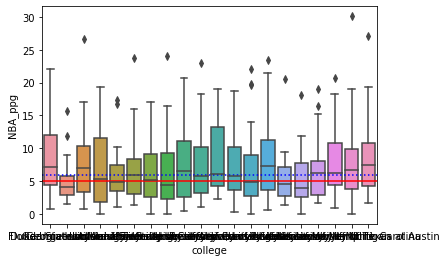

In [17]:
# Listing the colleges with at least 20 appearances in our dataframe
common_colleges = cleaned['college'].value_counts().reset_index(name='count').query('count > 20')['index']
common_colleges_data = cleaned.loc[cleaned['college'].isin(common_colleges)]

# Constructing the plot
box = sns.boxplot(x='college', y='NBA_ppg', data=common_colleges_data.sort_values('college'))
# Adding a median line based on all data
box.axhline(y=cleaned['NBA_ppg'].median(), color='red')
# Adding a median line for only common colleges
box.axhline(y=common_colleges_data['NBA_ppg'].median(), color='blue', linestyle='dotted')
plt.show()

Looking at our plot, we can (barely) see that the median for these common colleges is higher than that of all colleges. Some colleges have especially high median NBA ppgs, which we will address later. For now, let's see if there is a relationship between number of NBA players from a college and the median NBA ppg of these players (among only colleges with at least 5 players). If there is a relationship, we can add a column to 'cleaned' that accounts for the number of NBA players from the college that a given person attends. If there isn't a relationship, we will ignore this and simply address the colleges with especially high median NBA ppgs.

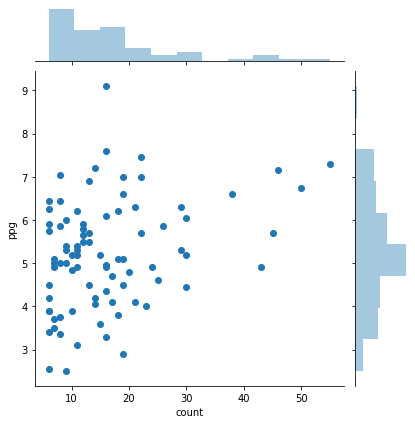

In [18]:
# Constructing a dataframe with all colleges, the counts of players, and the median ppg for each college.
all_colleges = pd.DataFrame(cleaned['college'].value_counts())
all_colleges['count'] = all_colleges['college']
all_colleges['college'] = all_colleges.index
all_colleges = all_colleges.reset_index().drop('index', axis=1)
all_colleges['ppg'] = [cleaned.loc[cleaned['college'] == college]['NBA_ppg'].median() for college in all_colleges['college']]

# Plotting the relation between number of players and median ppg in a scatter plot.
scat = sns.jointplot(x='count', y='ppg', data=all_colleges.loc[all_colleges['count'] > 5])

Looking at this graph, there does not seem to be a clear relationship between having more NBA players and these players having a higher ppg. Because of this, we will only add features for a few notable colleges with especially high numbers of players. For other colleges, we will make no change. Let's see which colleges have the highest NBA ppg - we'll call the top 10 colleges our best colleges and add a column to 'cleaned' named 'from_best_colleges' that will indicate whether a player is from one of these top 10 colleges.

In [19]:
# Creating a list of the best colleges, those that have produced more than 5 NBA players and have a median NBA ppg of more
# than 6.5.
best_colleges = all_colleges.loc[(all_colleges['count'] > 5) & (all_colleges['ppg'] > 6.5)]['college']

# Adding a column to cleaned that indicates whether or not a player is from one of the best colleges identified.
cleaned['from_best_colleges'] = cleaned['college'].isin(best_colleges).astype('int64')
cleaned.head()

,college,name,weight,NBA_ppg,NCAA__3ptapg,NCAA__3ptpct,NCAA__3ptpg,NCAA_fgapg,NCAA_fgpct,NCAA_fgpg,...,position=C-F,position=F,position=F-C,position=F-G,position=G,position=G-F,age_entering_NBA,years_in_NBA,height_inches,from_best_colleges
0,Duke University,Alaa Abdelnaby,240.0,5.7,0.0,0.000,0.0,5.6,0.599,3.3,...,0.0,0.0,1.0,0.0,0.0,0.0,23.0,4,82.0,1
3,Louisiana State University,Mahmoud Abdul-Rauf,162.0,14.6,7.2,0.372,2.7,21.9,0.474,10.4,...,0.0,0.0,0.0,0.0,1.0,0.0,22.0,10,73.0,0
5,University of California,Shareef Abdur-Rahim,225.0,18.1,0.8,0.381,0.3,14.2,0.518,7.4,...,0.0,1.0,0.0,0.0,0.0,0.0,21.0,11,81.0,0
10,Pepperdine University,Alex Acker,185.0,2.7,3.3,0.411,1.4,11.2,0.457,5.1,...,0.0,0.0,0.0,0.0,1.0,0.0,23.0,3,77.0,0
14,Baylor University,Quincy Acy,240.0,5.0,0.1,0.429,0.0,6.0,0.602,3.6,...,0.0,1.0,0.0,0.0,0.0,0.0,23.0,5,79.0,0


At this point, we have plenty of information on each player, and we are ready to construct a model. As we have a good amount of features, we'll attempt to avoid overfitting by using either lasso or ridge regularization. For each of these, we'll compare the different hyperparameters using cross validation, and we'll decide between the two models based on which has the lowest smallest cross validation error.

In [20]:
# Splitting data into X and Y.
X = cleaned.drop(['college', 'name', 'NBA_ppg'], axis=1)
Y = cleaned['NBA_ppg']

# Setting a random seed, splitting into train and test sets, and normalizing our X.
np.random.seed(1738)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
X_train_normalized = StandardScaler().fit_transform(X_train)
X_test_normalized = StandardScaler().fit_transform(X_test)

In [21]:
# Function that calculates an rmse score given a model, X, and Y - for use in the function cross_validation_score.
def rmse(model, X, Y):
    return np.sqrt(np.mean((Y - model.predict(X)) ** 2))

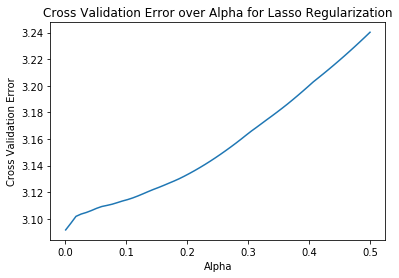

Best alpha for Lasso:  0.001
Best CV error for Lasso:  3.0916352188031984


In [22]:
# Placeholder alpha value, array of possible alpha values for our lasso regularization and empty array for cross 
# validation errors in lasso testing.
placeholder_alpha = 0.1
alpha_arr_lasso = np.linspace(0.001, 0.5, 60)
cv_errors_lasso = []

# Creating a model
model = Pipeline([("transformer", StandardScaler()), ("LinearModel", Lasso(max_iter=1000000))])

# Cycling through different possible alpha values
for alpha in alpha_arr_lasso:
    model.set_params(LinearModel__alpha=alpha)

    # Computing cross validation error for each
    cv_error = np.mean(cross_val_score(model, X_train, Y_train, scoring=rmse, cv=5))
    cv_errors_lasso.append(cv_error)
    
best_alpha_lasso = alpha_arr_lasso[np.argmin(cv_errors_lasso)]

# Plotting alpha against cross validation error
plt.plot(alpha_arr_lasso, cv_errors_lasso)
plt.title('Cross Validation Error over Alpha for Lasso Regularization')
plt.xlabel('Alpha')
plt.ylabel('Cross Validation Error')
plt.show()

print("Best alpha for Lasso: ", best_alpha_lasso)
print("Best CV error for Lasso: ", min(cv_errors_lasso))

In observing our graph, we see that even at our miniscule alpha values, the best alpha is closest to 0. An alpha near 0 approaches a linear model, so we could look at our coefficients and identify which of our columns are effectively useless in our model. If our CV error for the Lasso Regularization is lower than that of the Ridge Regularization, we will do this.

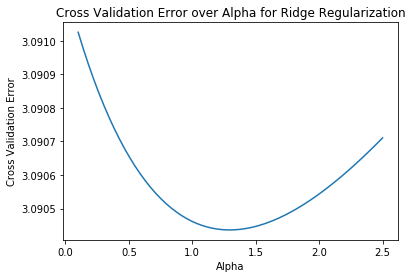

Best alpha for ridge:  1.2796610169491525
Best CV error for ridge:  3.090436413487489


In [23]:
# Placeholder alpha value, array of possible alpha values for our ridge regularization and empty array for cross 
# validation errors in ridge testing.
placeholder_alpha = 0.1
alpha_arr_ridge = np.linspace(0.1, 2.5, 60)
cv_errors_ridge = []

# Creating a model
model = Pipeline([("transformer", StandardScaler()), ("LinearModel", Ridge(placeholder_alpha))])

# Cycling through different possible alpha values
for alpha in alpha_arr_ridge:
    model.set_params(LinearModel__alpha=alpha)

    # Computing cross validation error for each
    cv_error = np.mean(cross_val_score(model, X_train, Y_train, scoring=rmse, cv=5))
    cv_errors_ridge.append(cv_error)
    
best_alpha_ridge = alpha_arr_ridge[np.argmin(cv_errors_ridge)]

# Plotting alpha against cross validation error
plt.plot(alpha_arr_ridge, cv_errors_ridge)
plt.title('Cross Validation Error over Alpha for Ridge Regularization')
plt.xlabel('Alpha')
plt.ylabel('Cross Validation Error')
plt.show()

print("Best alpha for ridge: ", best_alpha_ridge)
print("Best CV error for ridge: ", min(cv_errors_ridge))

As our best cross validation error for the ridge regularization (3.090) is ever so slightly lower than that of the lasso regularization (3.092), we choose our lasso-regularized model as our best! A rudimentary visualization of predicted ppg against actual ppg can demonstrate some of the trends in our model.

RMSE for train values:  3.0530869581489632
RMSE for test values:  3.523045250596224


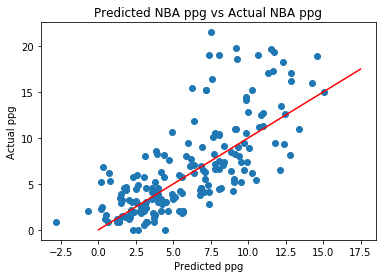

In [24]:
chosen_model = Pipeline([("transformer", StandardScaler()), ("LinearModel", Ridge(best_alpha_ridge))])
chosen_model.fit(X_train, Y_train)

print("RMSE for train values: ", rmse(chosen_model, X_train, Y_train))
print("RMSE for test values: ", rmse(chosen_model, X_test, Y_test))

plt.scatter(chosen_model.predict(X_test), Y_test)
plt.plot(np.linspace(0, 17.5, 10), np.linspace(0, 17.5, 10), color='red')
plt.title("Predicted NBA ppg vs Actual NBA ppg")
plt.xlabel('Predicted ppg')
plt.ylabel('Actual ppg')
plt.show()

Our RMSE of around 3 to 3.5 is not ideal, but for a student-constructed model of how many points per game an NBA player will average given their college information and statistics (a notoriously debated subject surrounding every NBA prospect even today), it isn't bad! The red line in the graph would represent perfect prediction; every predicted ppg would perfectly match the actual ppg. Preliminary analysis indicates that there is a roughly equal concentration of points both above and below the red line - our model does not have much of a tendency to over or underpredict. However, the scaling of the axes reveals that there is (obviously) plenty of potential for improving our model. It is impossible for anyone to average negative points per game, and our model should reflect this by never predicting a negative ppg. Additionally, the maximum predicted value is only around 15, while the highest ppg in our test set is a little above 20. The model's overall range for ppg is slightly incorrect, and it's accuracy would probably be much better if the range of predicted values was somehow shifted from (-2.5, 17.5) to (0, 20).

The analyses and observations throughout this document are only preliminary, and a deeper dive is available in the corresponding report. Additionally, the report includes a summary of findings and potential areas of improvement for the future.